# SHAP 模型可解释性分析

本 Notebook 专门用于对训练好的 DistilBERT 模型进行 SHAP 可解释性分析。

## 功能
- 加载已训练的模型（Baseline、LoRA、LoRA+数据增强）
- 使用 SHAP 分析模型决策依据
- 生成交互式可视化（文本高亮、条形图等）
- 保存可视化结果

## 关于 SHAP 值的说明

**重要提示**：SHAP 值反映的是"词对预测结果的边际贡献"，而非"词语本身的情感语义"。

中性词（如 "the", "is", "one"）也可能呈现正向 SHAP 值，原因包括：
1. **相对贡献**：移除中性词可能降低模型对整体语义的理解，从而降低预测信心
2. **语境模式**：模型学习到某些句法结构（如 "one of the best"）与积极情感相关
3. **贡献分摊**：SHAP 会将整体正向信号分配给所有词，包括结构性的中性词
4. **组合效应**：在序列模型中，中性词帮助构建完整语义，使情感词正确发挥作用

因此，中性词的正向 SHAP 值表示它"支持了当前预测趋势"，而非其本身具有积极情感。


## 1. 导入必要的库


In [53]:
# 1. 导入必要的库
import os
import sys

import torch
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

print("=== 库导入成功 ===")
print(f"PyTorch 版本: {torch.__version__}")
print(f"SHAP 版本: {shap.__version__}")

# 配置 matplotlib 支持中文显示（与 distilBERT.py 中保持一致）
font_list = ['SimHei', 'Microsoft YaHei', 'KaiTi', 'FangSong', 'STSong', 'Arial Unicode MS']
available_fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
chinese_font = None
for font in font_list:
    if font in available_fonts:
        chinese_font = font
        break

if chinese_font:
    plt.rcParams['font.sans-serif'] = [chinese_font]
else:
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"matplotlib 已配置中文字体: {chinese_font if chinese_font else '使用默认西文字体'}")


=== 库导入成功 ===
PyTorch 版本: 2.1.0
SHAP 版本: 0.44.1
matplotlib 已配置中文字体: SimHei


## 2. 配置和辅助函数


In [54]:
# 模型路径配置
MODEL_BASELINE_PATH = "./saved_models/baseline"
MODEL_LORA_PATH = "./saved_models/lora_basic"
MODEL_LORA_ADVANCED_PATH = "./saved_models/lora_advanced"

# 选择要分析的模型（可选：'baseline', 'lora', 'lora_advanced'）
SELECTED_MODEL = 'baseline'  # 可以修改为 'lora' 或 'lora_advanced'

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建可视化输出目录
os.makedirs("./visualizations/shap_notebook", exist_ok=True)
print(f"可视化结果将保存到: ./visualizations/shap_notebook/")


使用设备: cuda
可视化结果将保存到: ./visualizations/shap_notebook/


## 3. 加载模型和分词器


In [55]:
def load_model_and_tokenizer(model_path, model_type='baseline'):
    """
    加载已训练的模型和分词器
    
    Args:
        model_path: 模型保存路径
        model_type: 模型类型 ('baseline', 'lora', 'lora_advanced')
    """
    print(f"正在加载 {model_type} 模型...")
    
    # 加载分词器
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print(f"✅ 分词器加载成功")
    
    # 加载模型
    if model_type in ['lora', 'lora_advanced']:
        # 对于 LoRA 模型，需要先加载基础模型，再加载 PEFT 适配器
        base_model = AutoModelForSequenceClassification.from_pretrained(
            "./models/distilbert-base-uncased",
            num_labels=2
        )
        model = PeftModel.from_pretrained(base_model, model_path)
        print(f"✅ LoRA 模型加载成功")
    else:
        # Baseline 模型直接加载
        model = AutoModelForSequenceClassification.from_pretrained(
            model_path,
            num_labels=2
        )
        print(f"✅ Baseline 模型加载成功")
    
    model = model.to(device)
    model.eval()
    
    return model, tokenizer

# 根据选择加载模型
if SELECTED_MODEL == 'baseline':
    model, tokenizer = load_model_and_tokenizer(MODEL_BASELINE_PATH, 'baseline')
elif SELECTED_MODEL == 'lora':
    model, tokenizer = load_model_and_tokenizer(MODEL_LORA_PATH, 'lora')
elif SELECTED_MODEL == 'lora_advanced':
    model, tokenizer = load_model_and_tokenizer(MODEL_LORA_ADVANCED_PATH, 'lora_advanced')
else:
    raise ValueError(f"未知的模型类型: {SELECTED_MODEL}")

print(f"\n✅ 模型和分词器加载完成！模型类型: {SELECTED_MODEL}")


正在加载 baseline 模型...
✅ 分词器加载成功
✅ Baseline 模型加载成功

✅ 模型和分词器加载完成！模型类型: baseline


## 4. 定义 SHAP 预测函数


In [56]:
def shap_prediction_pipeline(text_list):
    """
    SHAP 需要的预测函数
    输入: 文本列表
    输出: 概率矩阵 [N, 2] (N个样本，2个类别)
    """
    # 确保输入是字符串列表
    if isinstance(text_list, str):
        text_list = [text_list]
    elif not isinstance(text_list, list):
        text_list = list(text_list)
    
    text_list = [str(text) for text in text_list]
    
    # 分词
    inputs = tokenizer(
        text_list,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    # 移到设备
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # 模型推理
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # 计算概率
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    return probs.cpu().numpy()

# 测试预测函数
test_texts = ["This movie is amazing!", "This movie is terrible..."]
test_probs = shap_prediction_pipeline(test_texts)
print("测试预测函数:")
print(f"输入: {test_texts}")
print(f"输出概率 (Negative, Positive):\n{test_probs}")
print("\n✅ 预测函数工作正常！")


测试预测函数:
输入: ['This movie is amazing!', 'This movie is terrible...']
输出概率 (Negative, Positive):
[[0.00578006 0.9942199 ]
 [0.99569196 0.0043081 ]]

✅ 预测函数工作正常！


## 5. 准备测试样本


In [57]:
# 选择要分析的文本样本
test_samples = [
    # 样本1：明显的积极评论
    "This is one of the best films I've ever seen. Truly brilliant and captivating.",
    
    # 样本2：明显的消极评论
    "I hated every second of this movie. It was a complete waste of time and money.",
    
    # 样本3：混合情感（转折）
    "The acting was decent and the cinematography was beautiful, but the plot was predictable and boring.",
    
    # 样本4：中性/模糊评论
    "The movie had its moments, but overall it was just okay. Nothing special.",
    
    # 样本5：复杂情感
    "While the special effects were impressive, the story lacked depth and the characters were poorly developed."
]

print(f"准备分析 {len(test_samples)} 个样本:")
for i, sample in enumerate(test_samples, 1):
    print(f"  {i}. {sample[:60]}...")


准备分析 5 个样本:
  1. This is one of the best films I've ever seen. Truly brillian...
  2. I hated every second of this movie. It was a complete waste ...
  3. The acting was decent and the cinematography was beautiful, ...
  4. The movie had its moments, but overall it was just okay. Not...
  5. While the special effects were impressive, the story lacked ...


## 6. 创建 SHAP 解释器并计算 SHAP 值


In [58]:
# 创建 SHAP 解释器
print("正在创建 SHAP 解释器...")
explainer = shap.Explainer(
    shap_prediction_pipeline,
    tokenizer,
    mask_token="[MASK]"
)
print("✅ SHAP 解释器创建成功")

# 计算 SHAP 值（这可能需要几分钟）
print("\n开始计算 SHAP 值...")
print("提示：这可能需要几分钟时间，请耐心等待...")
shap_values = explainer(test_samples)
print("\n✅ SHAP 值计算完成！")


正在创建 SHAP 解释器...
✅ SHAP 解释器创建成功

开始计算 SHAP 值...
提示：这可能需要几分钟时间，请耐心等待...

✅ SHAP 值计算完成！


## 7. 交互式文本可视化（Jupyter Notebook 最佳功能）

**这是 Jupyter Notebook 的核心优势！** 下面的代码会生成交互式的文本可视化，用颜色高亮显示每个词对预测的贡献：
- 🔴 **红色** = 推动模型预测为 Positive（积极）
- 🔵 **蓝色** = 推动模型预测为 Negative（消极）
- 颜色越深，影响越大


In [59]:
# SHAP 的交互式文本可视化（在 Jupyter 中效果最好）
# 这会显示文本，并用颜色高亮显示每个词对预测的贡献
# 红色 = 推向 Positive，蓝色 = 推向 Negative

print("生成交互式文本可视化...")
shap.plots.text(shap_values)


生成交互式文本可视化...


## 8. 条形图可视化（显示最重要的词）


生成条形图可视化...
样本 0 的条形图：


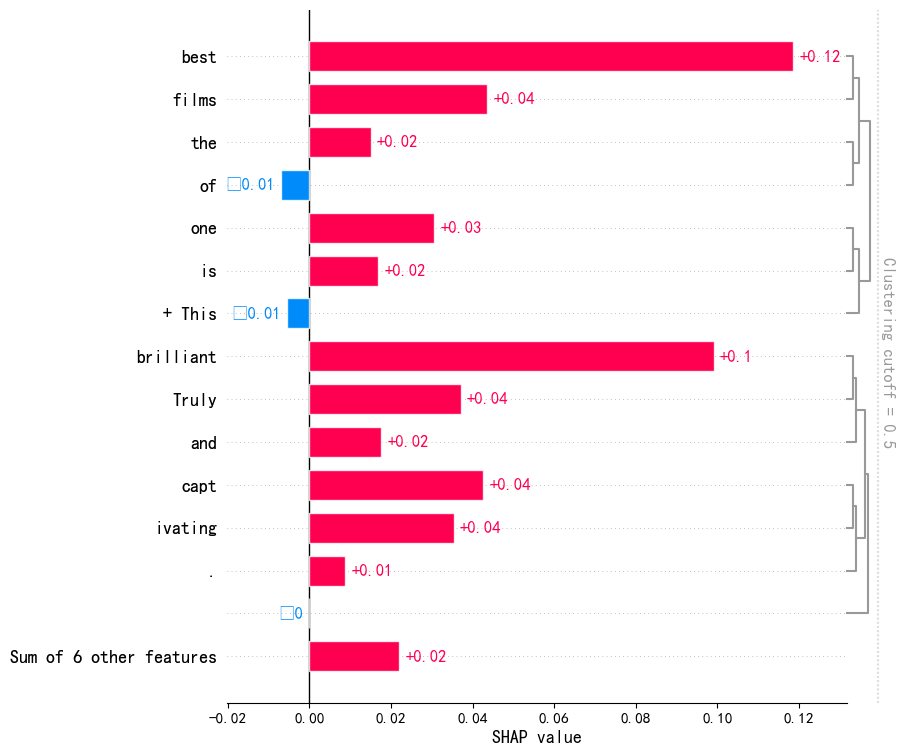

样本 1 的条形图：


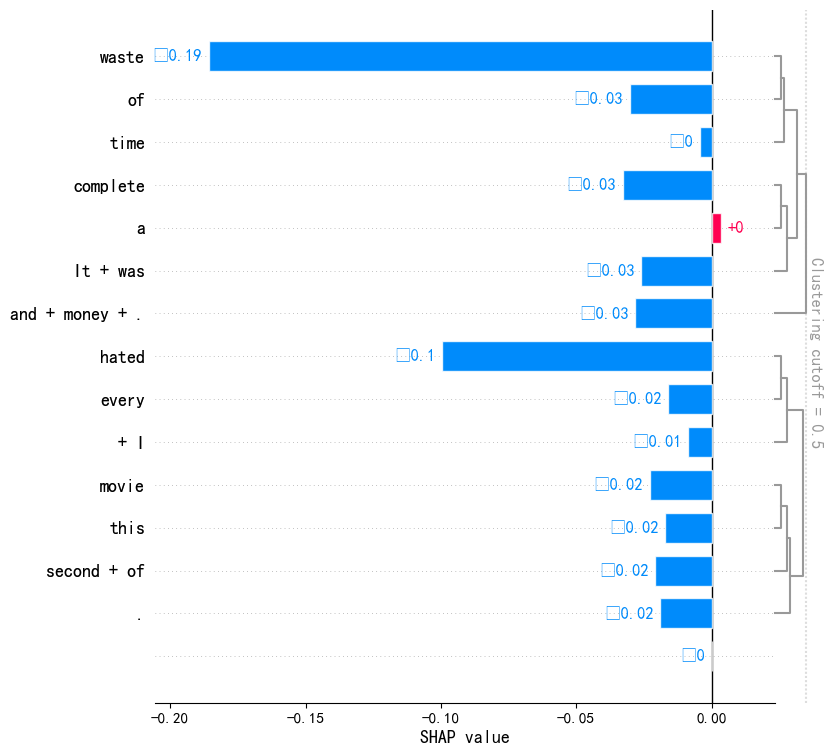

样本 2 的条形图：


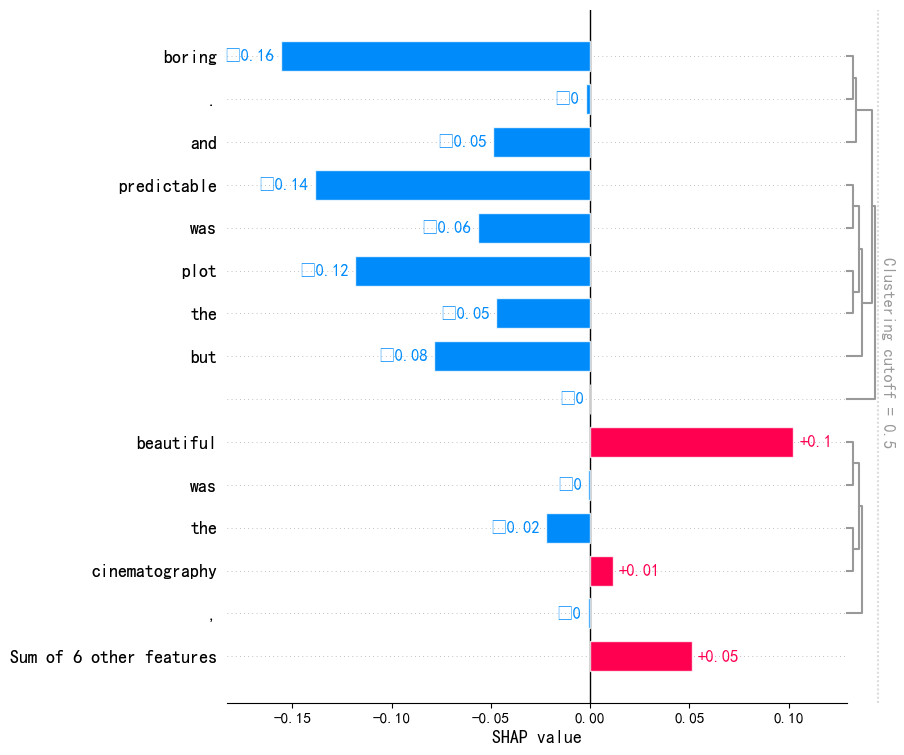

样本 3 的条形图：


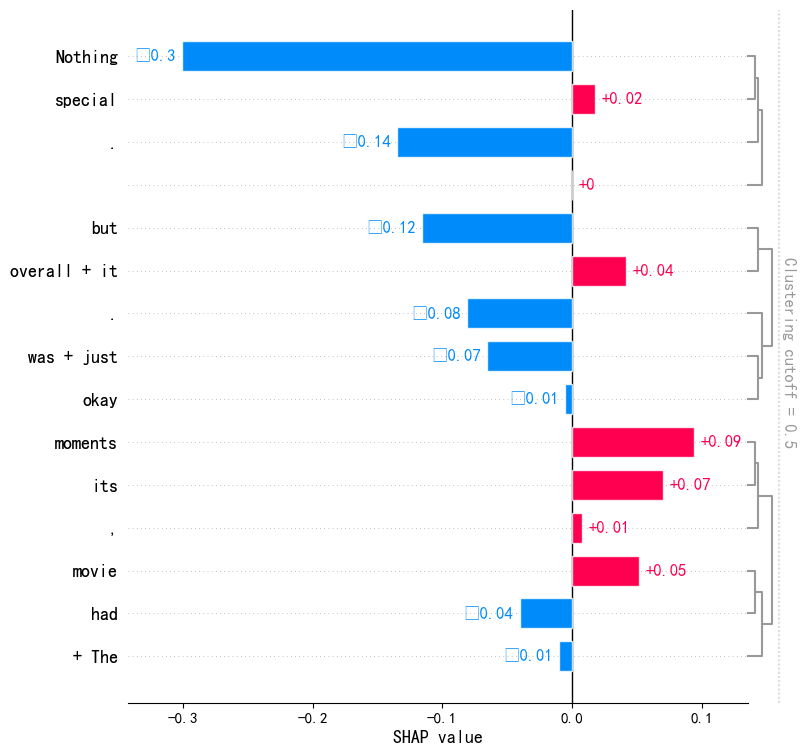

样本 4 的条形图：


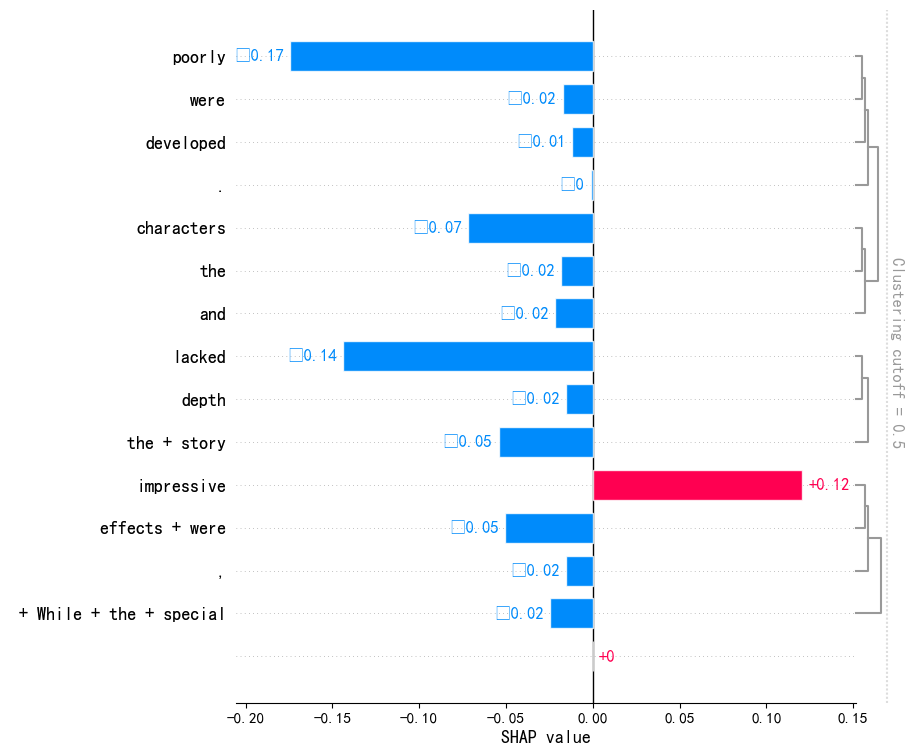

In [60]:
print("生成条形图可视化...")

for idx in range(len(shap_values)):
    print(f"样本 {idx} 的条形图：")
    shap.plots.bar(shap_values[idx, :, 1], max_display=15)

## 9. 单个样本详细分析

可以选择特定样本进行更详细的分析



=== 样本 1 详细分析 ===
文本: This is one of the best films I've ever seen. Truly brilliant and captivating.

生成该样本的可视化...


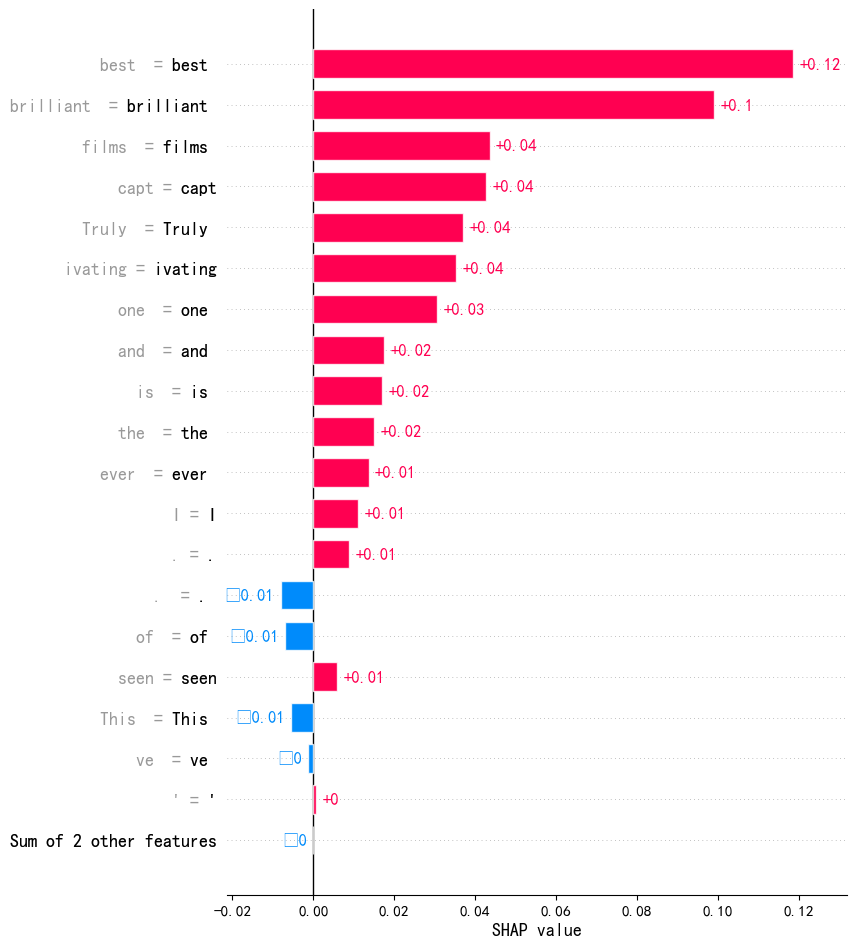

In [61]:
# 选择要详细分析的样本索引（0-4）
sample_idx = 0

print(f"\n=== 样本 {sample_idx + 1} 详细分析 ===")
print(f"文本: {test_samples[sample_idx]}")
print("\n生成该样本的可视化...")

sample_exp = shap_values[sample_idx]

# 单个样本的文本可视化（原始 Explanation 可直接使用）
shap.plots.text(sample_exp)

# 构建仅包含 Positive 类别贡献的 Explanation，避免 shap.plots.bar 多输出报错
if hasattr(sample_exp, "values"):
    sample_values = sample_exp.values
    sample_data = sample_exp.data
else:
    sample_values = sample_exp
    sample_data = None

if isinstance(sample_values, np.ndarray) and sample_values.ndim == 2:
    positive_values = sample_values[:, 1]
else:
    positive_values = sample_values

if sample_data is None:
    sample_tokens = tokenizer.tokenize(test_samples[sample_idx])
else:
    sample_tokens = list(sample_data)

max_len = min(len(sample_tokens), len(positive_values))
sample_tokens = sample_tokens[:max_len]
positive_values = positive_values[:max_len]

# 清理空字符串，避免 shap 内部 format_value 访问空 token 报错
clean_tokens = [tok if isinstance(tok, str) and tok.strip() else "[BLANK]" for tok in sample_tokens]

positive_exp = shap.Explanation(
    values=positive_values,
    base_values=0.0,
    data=clean_tokens,
    feature_names=clean_tokens
)

# 单个样本的条形图（Positive 类别）
shap.plots.bar(positive_exp, max_display=20)


## 10. 保存可视化结果

将可视化保存为图片文件，方便在报告中使用


In [62]:
# 为每个样本生成并保存可视化
save_dir = "./visualizations/shap_notebook"

for i, text in enumerate(test_samples):
    print(f"\n处理样本 {i+1}...")
    
    # 针对每个样本单独提取 Explanation，避免直接索引 shap_values.values 报错
    sample_exp = shap_values[i]
    if hasattr(sample_exp, "values"):
        sample_values = sample_exp.values
    else:
        sample_values = sample_exp
    
    if isinstance(sample_values, np.ndarray) and sample_values.ndim == 2:
        positive_values = sample_values[:, 1]
    else:
        positive_values = np.array(sample_values).reshape(-1)
    
    if hasattr(sample_exp, "data") and sample_exp.data is not None:
        tokens = list(sample_exp.data)
    else:
        tokens = tokenizer.tokenize(text)
    
    max_len = min(len(tokens), len(positive_values))
    tokens = tokens[:max_len]
    positive_values = positive_values[:max_len]
    
    # 清理空 token，防止绘图时格式化报错
    clean_tokens = [tok if isinstance(tok, str) and tok.strip() else "[BLANK]" for tok in tokens]
    
    # 创建可视化
    fig, ax = plt.subplots(figsize=(12, max(4, len(clean_tokens) * 0.3)))
    
    # 按贡献值排序
    contributions = list(zip(clean_tokens, positive_values))
    contributions_sorted = sorted(contributions, key=lambda x: abs(x[1]), reverse=True)
    
    # 显示前20个最重要的词
    top_n = min(20, len(contributions_sorted))
    top_tokens = [t[0] for t in contributions_sorted[:top_n]]
    top_values = [t[1] for t in contributions_sorted[:top_n]]
    
    # 绘制条形图
    colors = ['red' if v > 0 else 'blue' for v in top_values]
    ax.barh(range(len(top_tokens)), top_values, color=colors, alpha=0.7)
    ax.set_yticks(range(len(top_tokens)))
    ax.set_yticklabels(top_tokens)
    ax.set_xlabel('SHAP值 (对Positive类别的贡献)', fontsize=12)
    ax.set_title(f'样本 {i+1} - 最重要的词对预测的贡献\n"{text[:60]}..."', fontsize=14)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    filename = os.path.join(save_dir, f"SHAP_{SELECTED_MODEL}_sample_{i+1}_detailed.png")
    plt.savefig(filename, bbox_inches='tight', dpi=150)
    plt.close()
    
    print(f"  ✅ 已保存: {filename}")
    
    # 打印详细分析
    print(f"\n  前10个最重要的词:")
    for j, (token, value) in enumerate(contributions_sorted[:10], 1):
        direction = "→ Positive" if value > 0 else "→ Negative"
        print(f"    {j:2d}. {token:20s} | SHAP值: {value:+.4f} {direction}")

print(f"\n✅ 所有可视化已保存到: {save_dir}")



处理样本 1...
  ✅ 已保存: ./visualizations/shap_notebook\SHAP_baseline_sample_1_detailed.png

  前10个最重要的词:
     1. best                 | SHAP值: +0.1185 → Positive
     2. brilliant            | SHAP值: +0.0991 → Positive
     3. films                | SHAP值: +0.0436 → Positive
     4. capt                 | SHAP值: +0.0427 → Positive
     5. Truly                | SHAP值: +0.0371 → Positive
     6. ivating              | SHAP值: +0.0353 → Positive
     7. one                  | SHAP值: +0.0306 → Positive
     8. and                  | SHAP值: +0.0175 → Positive
     9. is                   | SHAP值: +0.0170 → Positive
    10. the                  | SHAP值: +0.0150 → Positive

处理样本 2...
  ✅ 已保存: ./visualizations/shap_notebook\SHAP_baseline_sample_2_detailed.png

  前10个最重要的词:
     1. waste                | SHAP值: -0.1858 → Negative
     2. hated                | SHAP值: -0.0995 → Negative
     3. complete             | SHAP值: -0.0329 → Negative
     4. of                   | SHAP值: -0.0303 → Negative


## 11. 分析总结


In [63]:
print("=== SHAP 可解释性分析总结 ===")
print(f"\n分析的模型: {SELECTED_MODEL}")
print(f"分析的样本数: {len(test_samples)}")
print("\n主要发现:")
print("1. 红色高亮的词推动模型预测为 Positive（积极）")
print("2. 蓝色高亮的词推动模型预测为 Negative（消极）")
print("3. 颜色越深，影响越大")
print("4. 可以通过条形图查看具体数值")
print("\n✅ 分析完成！所有可视化结果已保存。")


=== SHAP 可解释性分析总结 ===

分析的模型: baseline
分析的样本数: 5

主要发现:
1. 红色高亮的词推动模型预测为 Positive（积极）
2. 蓝色高亮的词推动模型预测为 Negative（消极）
3. 颜色越深，影响越大
4. 可以通过条形图查看具体数值

✅ 分析完成！所有可视化结果已保存。
